# BERT Toxic Comments Classification at E-Commerce Online Shop

### Project Description

**The project goal is to perform binary text classification using the BERT model.**

ABC online store is launching a new service. Now users can edit and supplement product descriptions, just like in wiki-communities. This means that clients can suggest their own edits and comment on changes made by others. The store needs a tool that will search for toxic comments and send them for moderation.

Train a model to classify comments into positive and negative categories. You have a dataset with annotations about the toxicity of edits.

Build a model with an F1-score of at least 0.75.

### Methodology

1. Load and prepare the data.
2. Train different models.
3. Draw conclusions.

### ML models

* *Logistic Regression*
* *CatBoost, LightGBM Classifiers*
* **BERT (Bidirectional Encoder Representations from Transformers)** is a Transformer pre-trained on masked language model and next sentence prediction tasks. This approach showed state-of-the-art results on a wide range of NLP tasks in English.

### Variables Description
The ```text``` column contains the comment text, and ```toxic``` columns is the target variable.

#### Data can be found [here](https://drive.google.com/file/d/1LKtXW3ea-VAzyszYqc49I8WCkHS1VtdL/view?usp=sharing).

In [80]:
import nltk
import pandas as pd

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from tqdm import tqdm
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import warnings

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from tqdm import tqdm

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font color=blue>
<b>Полезные ссылки по NLP</b>для изучения:

Основы Natural Language Processing для текста  — https://habr.com/ru/company/Voximplant/blog/446738/

Интересная статья в общем по NLP — https://habr.com/ru/company/oleg-bunin/blog/352614/

BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) — https://habr.com/ru/post/487358/

В частности, BERT является довольно популярной моделью. Вот еще информация по этой модели:

https://habr.com/ru/post/436878/

http://jalammar.github.io/illustrated-bert/; https://huggingface.co/docs/transformers/model_doc/bert

И другие ссылки:

http://jalammar.github.io/illustrated-word2vec/

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

http://jalammar.github.io/illustrated-transformer/

https://colab.research.google.com/drive/1SBha91u6142pW5mSiQOOjJWCCSAFj4HI?usp=sharing

</font>

[Nice reading about BERT](https://docs.deeppavlov.ai/en/master/features/models/bert.html)

BERT (Bidirectional Encoder Representations from Transformers) is a Transformer pre-trained on masked language model and next sentence prediction tasks. This approach showed state-of-the-art results on a wide range of NLP tasks in English.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dara Loading and Preprocessing</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclustions</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<div class="alert alert-warning">

<b>⚠️ PEP-8:</b> Желательно удалить лишние библиотеки из импорта, т.к. принято оставлять только те, которые будут использоваться в проекте. Как рекомендация, при написании кода, в частности оформлении импорта библиотек, стоит придерживаться стандарта [PEP-8](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html).

</div>

## Подготовка

In [81]:
# read the file handling exceptions
try:
    data = pd.read_csv("C:\\Users\\HOME\\PycharmProjects\\toxic_comments.csv", index_col=[0])
except FileNotFoundError:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [40]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [41]:
data.toxic.unique()

array([0, 1], dtype=int64)

In [42]:
# проверка на пропуски в таргете
data['toxic'].isna().sum()

0

### Проверка на дисбаланс таргета

In [43]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

### ***Вывод:*** Видим, что таргет не сбалансирован. Это нужно учесть при подготовке обучающей выборки. Так как для наилучшего обучения модели целевое значение должно быть сбалансировано.

### Работаем со стоп-словами

In [68]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Переведём тексты в стандартный для Python формат: кодировку Unicode U.

<div class="alert alert-danger">
<b> 🚫 Unicode:</b> Нужно убрать преобразование в юникод, т.к. текст на английском языке — это не требуется и занимает дополнительное время.

</div>

In [45]:
# Изменим кодировку методом astype():
# corpus = data['text'].values.astype('U')
# corpus_train = X_train.values.astype('U')
# corpus_test = X_test.values.astype('U')

### Создадим функцию для лемматизации и очистки текста

In [46]:
corpus = list(data['text'])

In [47]:
def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    
    lem_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    
    lem_final = re.sub(r'[^a-zA-Z ]', '', lem_text)
    
    return lem_final.lower()

<div class="alert alert-danger">
<b>Лемматизатор Mystem:</b> К сожалению лемматизатор Mystem подходит только для русского языка. Вместо него можно применить, например WordNetLemmatizer().
    
Пример кода можно взять из тренажера. Обрати внимание, что лемматизацию мы должны применять к каждому токену (слову в тексте). Например таким образом:
    
    lemm_text = " ".join(lemmatizer.lemmatize(word) for word in text.split())


</div>

<div class="alert alert-success">
<b>✔️Лемматизация:</b> На будущее, если будет интересно более углубленное изучение анализа текстов, можешь попробовать другие способы лемматизации.
    
1. Лемматизация с помощью Spacy. Но если делать на всем датасете, может занять 0,5-1 час, в зависимости от возможностей компьютера.
https://spacy.io/ или https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

2. Использовать POS-теги, это сделает лемматизацию точнее:
https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
    
Это занимает больше времени, поэтому можешь проверить локально, на небольшой выборке. 
    
Для контроля времени лемматизации, поскольку процесс длительный, можно применять индикатор прогресса. Различные варианты можно посмотреть здесь: 
    
https://habr.com/ru/post/483400/ 
    
Пример:
    
    from tqdm import tqdm
    tqdm.pandas()
    data['lemm_text'] = data['text'].progress_apply(lemmatize)

</div>

#### Протестируем работу функции лемматизации и очистки текста.

In [48]:
print("Исходный текст:", corpus[100])
print("Очищенный и лемматизированный текст:", lemmatize(corpus[100]))

Исходный текст: However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
Очищенный и лемматизированный текст: however the moonlite edit noted by golden daph wa me on optus  wake up wikkis so funny


<div class="alert alert-success">
<b>✔️ WordNetLemmatizer():</b> В данном примере и в тексте ниже видно, что очистка текста отработала, но преобразования к исходной форме не видно. Стоит отметить, что даже WordNetLemmatizer() преобразовывает далеко не все слова, но в целом по нескольким строчкам можно будет увидеть изменение.
    
</div>

#### Применим функцию для лемматизации и очистки текста

In [49]:
# applying the function without tracking the progress
# data['lem_text'] = data.text.apply(lemmatize)

# lemmatizing with tracking the progress
data['lem_text'] = data['text'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [00:26<00:00, 6040.91it/s]


In [50]:
data.head()

,text,toxic,lem_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he match this background colour im seemin...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


### Разделим данные на тестовую и обучающую выборки

In [52]:
features = data.drop(columns='toxic', axis=1)
target = data['toxic']

In [53]:
features.shape

(159292, 2)

In [54]:
target.shape

(159292,)

In [83]:
# Разделяю на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, 
                                                    random_state=5)

In [84]:
print('Train features sample size:', X_train.shape[0])
print('Train target sample size:', y_train.shape[0])
print()
print('Test features sample size:', X_test.shape[0])
print('Test target sample size:', y_test.shape[0])
print()
print('Test sample, %:', round(X_test.shape[0] / (X_test.shape[0] + X_train.shape[0]) * 100, 2))

Train features sample size: 127433
Train target sample size: 127433

Test features sample size: 31859
Test target sample size: 31859

Test sample, %: 20.0


### Проведем upsampling для корректировки дисбаланса таргетов в обучающей выборке

In [57]:
# функция upsample для создания сбалансированности выборки 
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]  
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=5)
    
    return features_upsampled, target_upsampled

In [58]:
# upsample for target disbalance correction
X_train_up, y_train_up = upsample(X_train,
                                  y_train,
                                  repeat = 5)

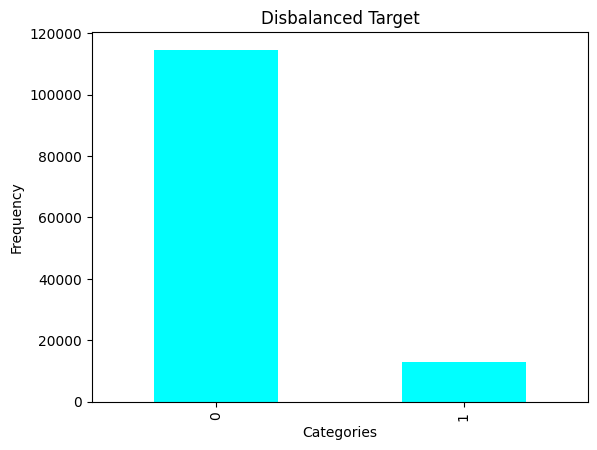

In [59]:
y_train.value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

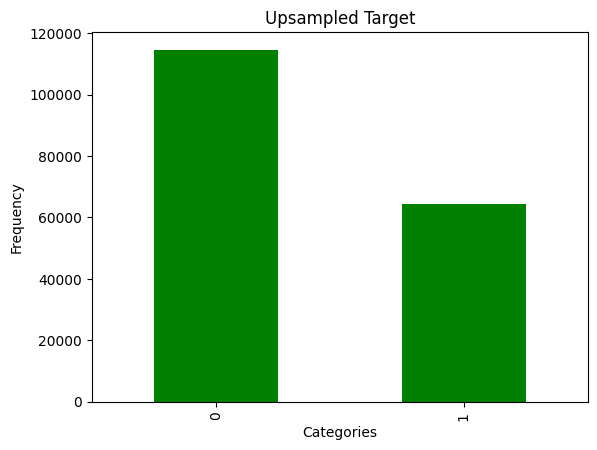

In [60]:
y_train_up.value_counts().plot(kind='bar', color='green')

plt.title('Upsampled Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

<div class="alert alert-warning">
<b>⚠️ Target Disbalance:</b>
    
Стоит отметить, что мы не обеспечили полный баланс классов, осталась некоторая несбалансированность. Это поможет для обучения модели, но не сильно. 
    
Поэтому лучше не останавливаться на полумерах.
    
В целом, рекомендую применить балансировку внутри моделей.
    
Вообще upsampling просто дублирует строчки в малом классе, новых данных он не приносит.
    
При анализе текстов применяют также аугментацию, например слова заменяют синонимами. Но это непростая задача, можно почитать [здесь](https://alexanderdyakonov.wordpress.com/2020/11/09/text-augmentation/#:~:text=%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20(augmentation)%20%E2%80%93%20%D1%8D%D1%82%D0%BE%20%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5,%D0%BC%D0%B5%D0%BD%D1%8F%D1%8E%D1%82%20(%D0%B8%D0%BD%D0%BE%D0%B3%D0%B4%D0%B0%20%D1%81%D1%83%D1%89%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE)%20%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8F).

</div>

### Таргетные значения теперь сбалансированы лучше, что положительно скажется на обучении.

### ВЫВОД: Исходные данные разделены на тестовые и обучающие, выделены признаки и таргетные значения. Дальнейшие преобразования текста будем производить только с признаками (текстом).

Применим модель "мешка слов" к набору данных.

### Реализуем модель «мешка слов» в классе CountVectorizer

Мы импортируем класс CountVectorizer, создам экземпляр класса и подгоняем модель к нашим данным для анализа тональности твитов.

In [63]:
# vect = CountVectorizer(stop_words=stopwords)
vect = CountVectorizer(stop_words='english')

In [65]:
# Считаю Tf-idf для обучающей
X_train_vect = vect.fit_transform(X_train.lem_text)

# Считаю Tf-idf для тестовой
X_test_vect = vect.transform(X_test.lem_text)

Перед тем как мы пытаемся улучшить выделение признаков, давайте измерим качество модели, построив классификатор. 

У нас есть обучающие метки, хранящиеся в y_train и обучающие данные, представленные в виде «мешка слов» X_train, таким образом, мы можем обучить классификатор по этим данным. 

Как правило, для подобных высокоразмерных разреженных данных лучше всего работают линейные модели типа LogisticRegression.

### Масштабирование признаков с помощью TF-IDF

Следующий подход вместо исключения несущественных признаков пытается масштабировать признаки в зависимости от степени их информативности. Одним из наиболее распространенных способов такого масштабирования является метод частота термина-обратная частота документа (term frequency-inverse document frequency, tf-idf). 

**Идея этого метода заключается в том, чтобы присвоить большой вес термину, который часто встречается в конкретном документе, но при этом редко встречается в остальных документах корпуса. Если слово часто появляется в конкретном документе, но при этом редко встречается в остальных документах, оно, вероятно, будет описывать содержимое этого документа лучше.**

Мешок слов учитывает частоту употребления слов. Посмотрим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

#### TFIDF = TF * IDF

IDF нужна в формуле, чтобы уменьшить вес слов, наиболее
распространённых в любом другом тексте заданного корпуса.
IDF зависит от общего числа текстов в корпусе (D) и количества
текстов, в которых это слово встречается (d).

Большая величина TF-IDF говорит об уникальности слова в тексте
по отношению к корпусу. Чем чаще оно встречается в конкретном
тексте и реже в остальных, тем выше значение TF-IDF.

**Если данные разделены на обучающую и тестовую выборки,
функцию fit() запустим только на обучающей. Иначе тестирование
будет нечестным: в модели будут учтены частоты слов из тестовой
выборки.**

Сначала переведем выборки X_train, X_test в векторный вид.


In [74]:
count_tf_idf = TfidfVectorizer(stop_words='english')

#### ***Несбалансированная выборка таргетов***

In [75]:
# Считаю Tf-idf для обучающей
tf_idf_X_train = count_tf_idf.fit_transform(X_train['lem_text'])

# Считаю Tf-idf для тестовой
tf_idf_X_test = count_tf_idf.transform(X_test['lem_text'])

In [76]:
print("Размер матрицы TF-IDF X_train:", tf_idf_X_train.shape)
print("Размер матрицы TF-IDF X_test:", tf_idf_X_test.shape)

Размер матрицы TF-IDF X_train: (127433, 190842)
Размер матрицы TF-IDF X_test: (31859, 190842)


#### ***Cбалансированная выборка таргетов***

In [77]:
# Считаю Tf-idf для обучающей
tf_idf_X_train_up = count_tf_idf.fit_transform(X_train_up['lem_text'])

In [78]:
print("Размер матрицы TF-IDF X_train_up:", tf_idf_X_train_up.shape)

Размер матрицы TF-IDF X_train_up: (179009, 190842)


### ВЫВОД: Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

## Обучение

<div class="alert alert-success">
<b>✔GridSearchCV:</b> На будущее хочу посоветовать, как можно улучшить обучение моделей, в том числе и для задач предсказания тональности текста.
    
Обычно мы обучаем на выборке train и применяем кросс-валидацию, например GridSearchCV. Но когда используется кросс-валидация, получается, что модель в итоге обучается на всей обучающей выборке и это немного не правильно — происходит утечка данных. 
    
В таких случаях рекомендуется оборачивать конструкцию в Pipeline. Вот здесь можно посмотреть примеры применения:
    
https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05
    
https://habr.com/ru/post/538458/
    
Pipeline + GridSearchCV: https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4
    
Таким образом в GridSearchCV можно добавить пайплайн — но это не обязательно для выполнения данной работы.
    
В данном случае в pipeline можно завести функцию upsampling, tf-idf и модель для машинного обучения.
</div>

### Logistic Regression с использованием перекрестной проверки для модели «мешка слов» в классе CountVectorizer()

In [85]:
pipe_lr = Pipeline([('vect', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('model', LogisticRegression())])

model = pipe_lr.fit(X_train, y_train)

prediction = model.predict(X_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))

ValueError: Found input variables with inconsistent numbers of samples: [2, 127433]

In [86]:
type(X_train)

pandas.core.frame.DataFrame

In [29]:
logreg = LogisticRegression(class_weight = 'balanced', 
                            random_state=5)

In [30]:
param_grid = [
    {'C': [0.01, 0.1, 1, 2, 10, 100], 
     'penalty': ['l1', 'l2']}
]

<div class="alert alert-warning">
<b>⚠️ scoring='f1':</b> По умолчанию в функции GridSearchCV рассчитывается метрика accuracy. В данном задании нас интересует F-мера. Нужно добавить целевую метрику:
    
    scoring='f1'

Поскольку классы несбалансированы, метрика accuracy не позволяет правильно оценить качество обучения. Подробнее о дисбалансе классов и влиянии на задачи можно почитать здесь:
    
https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/
</div>

In [69]:
logreg_grid = GridSearchCV(logreg, 
                           param_grid, 
                           cv=3, 
                           verbose=False, 
                           n_jobs=-1,
                          scoring='f1')

logreg_grid.fit(X_train_vect, y_train)

import warnings 
warnings.filterwarnings('ignore')

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

<div class="alert alert-warning">
<b>⚠️ Warning:</b> В процессе расчета возникает предупреждение, что расчет не сходится. Можно увеличить параметр max_iter:
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
Еще можно отключит предупреждения:
    
    import warnings 
    warnings.filterwarnings('ignore')
</div>

In [32]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(logreg_grid.best_score_))
print("Наилучшие параметры: ", logreg_grid.best_params_)

Наилучшее значение перекрестной проверки: 0.75
Наилучшие параметры:  {'C': 2, 'penalty': 'l2'}


In [70]:
y_pred_vect = logreg_grid.predict(tf_idf_X_train)
confusion_matrix(y_pred_vect, y_train)

array([[114086,   3746],
       [   453,   9148]])

<div class="alert alert-danger">
<b>🚫 Confusion MAtrix:</b> Во всех моделях нужно убрать расчет предсказаний на тестовой выборке и матрицы ошибок. иначе происходит переобучение, т.е. мы подглядываем в ответ.
    
Тестовую выборку нужно оставить только один раз, для проверки лучшей модели.
    
</div>

<div class="alert alert-info"> <b>ℹ️v2:</b>
    

    y_pred_vect = logreg_grid.predict(tf_idf_X_train)
    confusion_matrix(y_pred_vect, y_train)

</div>

<div class="alert alert-success">
<b>✔️v3:</b> Матрицу ошибок на кросс-валидации можно вывести таким образом:
    
    from sklearn.model_selection import cross_val_predict
    
    y_pred_vect = cross_val_predict(logreg_grid, X_train_vect, y_train, cv=5)
    conf_matrix = confusion_matrix(y_train, y_pred_vect)
    
Чуть подробнее можно посмотреть здесь:
    
https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
  
</div>

### ***Вывод:*** Полученная confusion_matrix представляет собой массив размером 2x2, где строки соответствуют фактическим классам, а столбцы соответствуют спрогнозированным классам. В данном случае речь идет о классах 0 и 1, то есть нетоксичный (0) и токсичный (1) комментарий.

Число в каждой ячейке показывает количество примеров, когда спрогнозированный класс, представленный столбцом, совпадает или не совпадает с фактическим классом, представленным строкой.

#### В полученной матрице видим, что элементы главной диагонали (28553 --> 0, 2011 --> 1) соответствуют правильным прогнозам (результатам классификации), тогда как остальные элементы показывают, сколько примеров, относящихся к одному классу, были ошибочно классифицированы как другой класс.

**Получается, что фактический класс 0 (28553) и спрогнозированный класс 0 (14) прогнозируется довольно точно. В то время, как фактический класс 1 (1281) прогнозируется с низкой точностью: только 1281 класс действительно является классом 1 из 2011 наблюдений, тогда как 2011 - ложно положительны. Эту модель точно нельзя рекомендовать к использованию.**

### Logistic Regression с использованием решетчатого поиска для модели «мешка слов» в классе TfidfVectorizer()

Поскольку tf-idf фактически использует статистические свойства
обучающих данных, мы воспользуемся конвейером, чтобы убедиться в достоверности результатов решетчатого поиска.

#### Обучим модель на несбалансированной выборке таргетов

In [82]:
logreg_tfidf = LogisticRegression(class_weight = 'balanced',
                                  random_state=5)

In [35]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(logreg_tfidf, 
                    param_grid, 
                    cv=3,
                   scoring='f1')

grid.fit(tf_idf_X_train, y_train)

print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

import warnings 
warnings.filterwarnings('ignore')

Наилучшее значение перекрестной проверки: 0.76


#### Обучим модель на сбалансированной выборке таргетов

In [36]:
logreg_tfidf_up = LogisticRegression(random_state=5)

param_grid_up = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_up = GridSearchCV(logreg_tfidf_up, 
                    param_grid_up, 
                    cv=3,
                   scoring='f1')

grid_up.fit(tf_idf_X_train_up, y_train_up)

import warnings 
warnings.filterwarnings('ignore')

### CatBoost в модели "мешка слов" в классе TfidfVectorizer()

In [38]:
# initiatint the model
catboost = CatBoostClassifier(random_seed=5,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations':[40], 
                  'learning_rate': np.arange(0.1,1,0.2)}

gsearch_catboost = GridSearchCV(catboost, 
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                               scoring='f1')

gsearch_catboost.fit(tf_idf_X_train, y_train)

0:	learn: 0.5933380	total: 4.6s	remaining: 2m 59s
1:	learn: 0.5175725	total: 7.28s	remaining: 2m 18s
2:	learn: 0.4577321	total: 8.78s	remaining: 1m 48s
3:	learn: 0.4124881	total: 10.1s	remaining: 1m 30s
4:	learn: 0.3776291	total: 11.5s	remaining: 1m 20s
5:	learn: 0.3478793	total: 12.9s	remaining: 1m 13s
6:	learn: 0.3246453	total: 14.7s	remaining: 1m 9s
7:	learn: 0.3068377	total: 16.7s	remaining: 1m 6s
8:	learn: 0.2921749	total: 18.4s	remaining: 1m 3s
9:	learn: 0.2791147	total: 19.6s	remaining: 58.9s
10:	learn: 0.2697044	total: 21.3s	remaining: 56s
11:	learn: 0.2619188	total: 22.8s	remaining: 53.2s
12:	learn: 0.2555392	total: 24.1s	remaining: 50.1s
13:	learn: 0.2499542	total: 26.1s	remaining: 48.5s
14:	learn: 0.2454003	total: 30s	remaining: 50s
15:	learn: 0.2415229	total: 31.5s	remaining: 47.3s
16:	learn: 0.2379865	total: 33.3s	remaining: 45.1s
17:	learn: 0.2347276	total: 35.4s	remaining: 43.3s
18:	learn: 0.2322673	total: 38s	remaining: 42s
19:	learn: 0.2292300	total: 40.2s	remaining: 4

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x13cde7340>,
             param_grid={'iterations': [40],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='f1', verbose=False)

In [67]:
y_pred_catboost = gsearch_catboost.predict(tf_idf_X_train)
confusion_matrix(y_pred_catboost, y_train)

array([[113497,   4254],
       [  1042,   8640]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а миноритарный дает больше половины ложноположительной ответов FP=1155.

### Gradient Boosting в модели "мешка слова" в классе TfidfVectorizer()

In [39]:

import lightgbm as lgb

In [40]:
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=5)

In [41]:
params_LGBMClassifier = {    
    
    'n_estimators': [50, 100], 
    'learning_rate': [0.05, 0.1], 
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
#     'random_state' : [5],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model, 
                                     cv=3, 
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(tf_idf_X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=5),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [50, 100], 'verbose': [-1]},
             scoring='f1')

In [65]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(tf_idf_X_train)
confusion_matrix(y_pred_lightgbm, y_train)

array([[109401,   1991],
       [  5138,  10903]])

### ***Вывод:*** Видим, что мажоритарный класс предсказывается хорошо, а вот миноритарный снова дает больше половины ложноположительной ответов FP=1230.

### Сравним модели

In [54]:
# Logistic Regression CountVectorizer
best_score_vect = round(logreg_grid.best_score_, 2)
print("Best score Logistic Regression CountVectorizer: {:.2f}".format(best_score_vect))

# f1_logreg_vect = round(f1_score(logreg_grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_vect))

Best score Logistic Regression CountVectorizer: 0.75


In [55]:
# Logistic Regression TF-IDF
best_score_tfidf = round(grid.best_score_, 2)
print('Best score Logistic Regression (TF-IDF): {:.2f}'.format(best_score_tfidf))

# f1_logreg_tfidf = round(f1_score(grid.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_logreg_tfidf))

Best score Logistic Regression (TF-IDF): 0.76


In [56]:
# Logistic Regression TF-IDF (upsampled)
best_score_tfidf_up = round(grid_up.best_score_, 2)
print('Best score Logistic Regression (TF-IDF): {:.2f}'.format(best_score_tfidf_up))

Best score Logistic Regression (TF-IDF): 0.96


In [57]:
# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 2)
print('Best score CatBoostClassifier (TF-IDF): {}'.format(best_score_catboost))

# f1_catboost = round(f1_score(gsearch_catboost.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_catboost))

Best score CatBoostClassifier (TF-IDF): 0.73


In [58]:
# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 2)
print('Best score LGBMClassifier (TF-IDF): {}'.format(best_score_LGBM))

# f1_lgbm = round(f1_score(LGBMClassifier_gsearch.predict(tf_idf_X_train), y_train), 2)
# print("F1-score Logistic Regression CountVectorizer: {:.2f}".format(f1_lgbm))

Best score LGBMClassifier (TF-IDF): 0.72


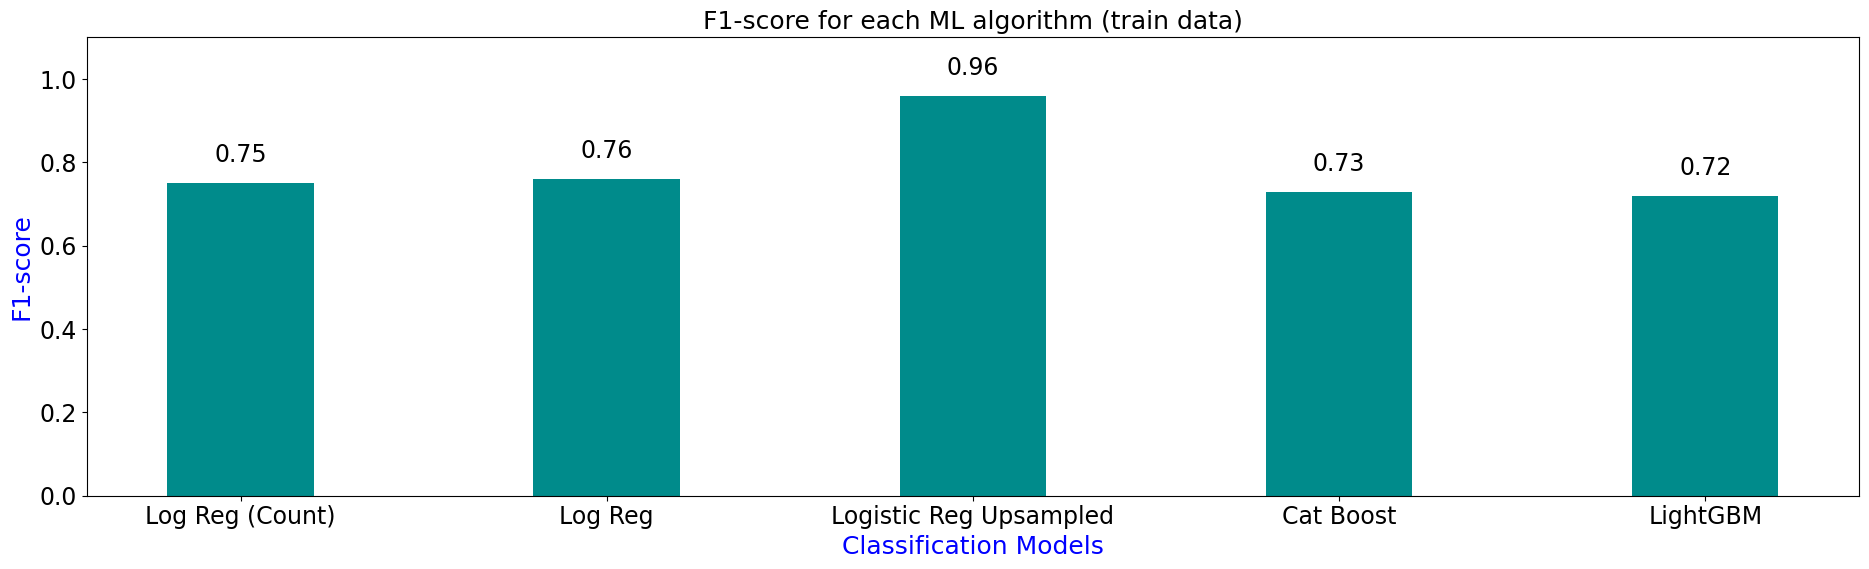

In [68]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17, 
                     'text.color' : 'black', 
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Count)',
     'Log Reg', 
     'Logistic Reg Upsampled', 
     'Cat Boost',
    'LightGBM']

y = [best_score_vect, 
     best_score_tfidf, 
     best_score_tfidf_up,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=18)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout();

###  Вывод: Максимальное значение F1-меры приходится на модель логистической регрессии (F1-score = 0.76), построенные для модели TD-IDF на выборке с учетом дисбалансов таргетов (upsampled). ***Протестируем оба алгоритма на тестовой выборке.***

## Выводы

In [61]:
# Logistic Regression TF-IDF (upsampled)
f1_logreg_tfidf_test_up = round(f1_score(grid_up.predict(tf_idf_X_test), y_test), 2)
print("F1-score Logistic Regression TF-IDF (test data): {:.2f}".format(f1_logreg_tfidf_test_up))

F1-score Logistic Regression TF-IDF (test data): 0.78


In [62]:
y_pred_logreg_up = grid_up.predict(tf_idf_X_test)
confusion_matrix(y_pred_logreg_up, y_test)

array([[27685,   647],
       [  882,  2645]])

In [73]:
print('\n',classification_report(y_test, y_pred_logreg_up))


               precision    recall  f1-score   support

           0       0.98      0.97      0.97     28567
           1       0.75      0.80      0.78      3292

    accuracy                           0.95     31859
   macro avg       0.86      0.89      0.87     31859
weighted avg       0.95      0.95      0.95     31859



### ***Вывод:*** Наилучшая модель классификации текста комментариев твиттера - это логистическая регрессия с максимальным значением F1-меры 0.78, построенная на модели "мешка слов". Модель построена после корректировки дисбалансов таргетов методом upsampling. Главгая диагональ сonfusion matrix демонстрирует, что модель обучается хорошо: количство ложно пложительных и ложно отрицательных предсказаний менее 20%.

### Вывод: Наилучшая модель классификации текста - это логистическая регрессия с максимальным значением F1-меры.

**Best wishes, Yulia**
Telegram: ```ybezginova_de```
Email: ```ybezginova2021@gmail.com```
